<a href="https://colab.research.google.com/github/sayakpaul/robustness-vit/blob/main/imagenet_results/imagenet_a/BiT_ImageNet_A_Assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference:
* https://colab.research.google.com/github/google-research/big_transfer/blob/master/colabs/big_transfer_tf2.ipynb

## Setup

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds 

import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
BATCH_SIZE = 32 # Reduce if ResourceExhaustedError happens
AUTO = tf.data.AUTOTUNE

## Data loader

In [3]:
def preprocess_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)  
    image = tf.image.resize(image, (224, 224))
    return image, label

In [4]:
imagenet_a = tfds.load("imagenet_a", split="test", as_supervised=True)
imagenet_a = (
    imagenet_a
    .map(preprocess_image, num_parallel_calls=True)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
image_batch, label_batch = next(iter(imagenet_a))
print(image_batch.shape, label_batch.shape)

(32, 224, 224, 3) (32,)


## Assessment

In [5]:
module_urls = [
    "https://tfhub.dev/google/bit/m-r50x1/ilsvrc2012_classification/1",
    "https://tfhub.dev/google/bit/m-r50x3/ilsvrc2012_classification/1",
    "https://tfhub.dev/google/bit/m-r101x1/ilsvrc2012_classification/1",
    "https://tfhub.dev/google/bit/m-r101x3/ilsvrc2012_classification/1",
    "https://tfhub.dev/google/bit/m-r152x4/ilsvrc2012_classification/1"
]

In [6]:
top_1_accs = {}
top_5_accs = {}
for module_url in tqdm(module_urls):
    variant = module_url.split("/")[5]
    print(f"Evaluating {variant}")
    imagenet_module = tf.keras.Sequential([hub.KerasLayer(module_url),
                                       tf.keras.layers.Softmax()])
    imagenet_module.compile(loss="sparse_categorical_crossentropy", 
                        metrics=[tf.keras.metrics.SparseCategoricalAccuracy(), 
                                 tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)])
    _, acc, acc_5 = imagenet_module.evaluate(imagenet_a, verbose=0)
    
    print(f"Top-1 accuracy: {acc*100}%")
    print(f"Top-5 accuracy: {acc_5*100}%")
    top_1_accs[variant] = acc
    top_5_accs[variant] = acc_5

  0%|          | 0/5 [00:00<?, ?it/s]

Evaluating m-r50x1
Top-1 accuracy: 4.1733331978321075%
Top-5 accuracy: 14.14666622877121%
Evaluating m-r50x3
Top-1 accuracy: 8.62666666507721%
Top-5 accuracy: 23.280000686645508%
Evaluating m-r101x1
Top-1 accuracy: 6.4133331179618835%
Top-5 accuracy: 18.373332917690277%
Evaluating m-r101x3
Top-1 accuracy: 10.426666587591171%
Top-5 accuracy: 25.61333477497101%
Evaluating m-r152x4
Top-1 accuracy: 13.146667182445526%
Top-5 accuracy: 28.466665744781494%


In [7]:
f = open("top_1_imagnet_a_bit.pkl", "wb")
f.write(pickle.dumps(top_1_accs))
f.close()
     
f = open("top_5_imagnet_a_bit.pkl", "wb")
f.write(pickle.dumps(top_5_accs))
f.close()

## Plots

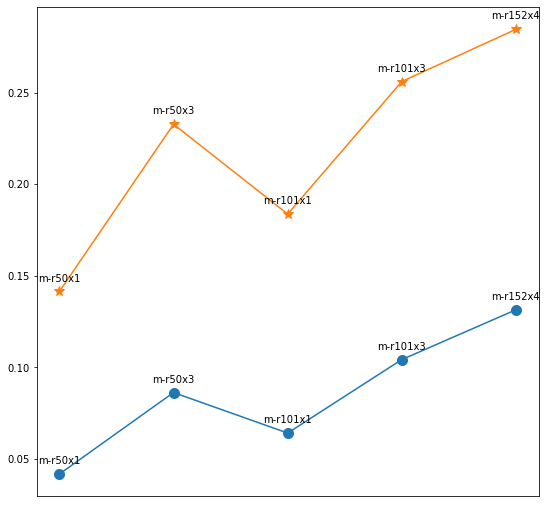

In [9]:
plt.figure(figsize=(9, 9))
plt.plot(top_1_accs.values(), marker=".", markersize=20)
plt.plot(top_5_accs.values(), marker="*", markersize=10)
xs = np.arange(0, 5, 1)

# Reference: https://queirozf.com/entries/add-labels-and-text-to-matplotlib-plots-annotation-examples
for i, (x, y) in enumerate(zip(xs, top_1_accs.values())):
    label = list(top_1_accs.keys())[i]
    plt.annotate(label, # this is the text
         (x, y), # this is the point to label
         textcoords="offset points", # how to position the text
         xytext=(0, 10), # distance from text to points (x,y)
         ha='center') # horizontal alignment can be left, right or center
    
for i, (x, y) in enumerate(zip(xs, top_5_accs.values())):
    label = list(top_1_accs.keys())[i]
    plt.annotate(label, # this is the text
         (x, y), # this is the point to label
         textcoords="offset points", # how to position the text
         xytext=(0, 10), # distance from text to points (x,y)
         ha='center') # horizontal alignment can be left, right or center
plt.xticks([])
plt.savefig("imagenet_a_bit.png", dpi=300, bbox_inches="tight")